# Logical Workflow

In [74]:
import os
import string
import re
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
df = pd.read_csv('/Users/ramyaamudapakula/Desktop/Summer/Data Analytics/Project/Otakuviz/data/anime-dataset-2023.csv')

In [75]:
# Function to preprocess data
def preprocess_data(df):
    columns_to_drop = ['Premiered', 'English name', 'Other name', 'Producers', 'Licensors', 'Studios', 'Image URL']
    df.drop(columns=columns_to_drop, inplace=True)
    df = df[(df['Rating'] != 'UNKNOWN') & (df['Episodes'] != 'UNKNOWN') & (df['Rank'] != 'UNKNOWN') & 
            (df['Type'] != 'UNKNOWN') & (df['Genres'] != 'UNKNOWN') & (df['Duration'] != 'Unknown') & 
            (df['Source'] != 'Unknown') & (df['Score'] != 'UNKNOWN')].copy()
    df['Award Winning'] = df['Genres'].apply(lambda x: "Yes" if "Award Winning" in x else "No")
    df['Genres'] = df['Genres'].str.replace(",? Award Winning,?", "", regex=True)
    df['Episodes'] = pd.to_numeric(df['Episodes'], errors='coerce')
    df['Duration'] = df['Duration'].str.replace(' min per ep', '', regex=False)
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
    
    df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
    df['Type'] = df['Type'].astype('category')
    df['Status'] = df['Status'].astype('category').str.strip().str.lower().replace({
        'finished airing': 'finished',
        'currently airing': 'ongoing',
        'not yet aired': 'upcoming'
    })
    df['Aired'] = pd.to_datetime(df['Aired'], errors='coerce')
    return df
df = preprocess_data(df)

/var/folders/pv/kll1prqs39jc2wvhvd31dfmr0000gn/T/ipykernel_40631/2167662300.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Aired'] = pd.to_datetime(df['Aired'], errors='coerce')


In [76]:
#Feature Extraction 
# Text preprocessing functions
def remove_punctuation_and_turn_lower(text):
    translator = str.maketrans('', '', string.punctuation)
    return (text.translate(translator)).lower()

def string_cleaning(string_list):
    strings_limpas = [remove_punctuation_and_turn_lower(string) for string in string_list]
    strings_limpas_no_numbers = [re.sub(r'\d', '', string) for string in strings_limpas]
    new_list = [item for item in strings_limpas_no_numbers if item]
    tokens_without_sw = [word for word in new_list if not word in stopwords.words('english')]
    ps = PorterStemmer()
    steemed_words = [ps.stem(w) for w in tokens_without_sw]
    return steemed_words

def preprocess_synopsis(df):
    df['Synopsis'] = df['Synopsis'].apply(lambda x: x.split() if isinstance(x, str) else [])
    df['Synopsis_cleaned'] = df['Synopsis'].apply(string_cleaning)
    df['Synopsis_cleaned_text'] = df['Synopsis_cleaned'].apply(lambda x: ' '.join(x))
    vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=5000)
    df['Synopsis_vectorized'] = list(vectorizer.fit_transform(df['Synopsis_cleaned_text']).toarray())
    return df
df = preprocess_synopsis(df)

In [77]:
# Feature selection
df_model = df[['Favorites', 'Members', 'Award Winning', 'Episodes', 'Score']].copy()
df_model = df_model.dropna()
df_model['Award Winning'] = df_model['Award Winning'].apply(lambda x: 1 if x == "Yes" else 0)

X = df_model.drop(columns=['Score'])
y = df_model['Score']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

Mean Squared Error: 0.4097185576442982
RMSE: 0.6400926164581953
MAE: 0.4623865299164755


In [79]:
def calculate_similarity(df):
    similarities = cosine_similarity(df['Synopsis_vectorized'].tolist())
    return similarities
similarities = calculate_similarity(df)

                              RMSE       MAE
Linear Regression         0.880994  0.686968
Decision Tree             0.815676  0.602940
Random Forest             0.640093  0.462387
Support Vector Regressor  0.735996  0.559121


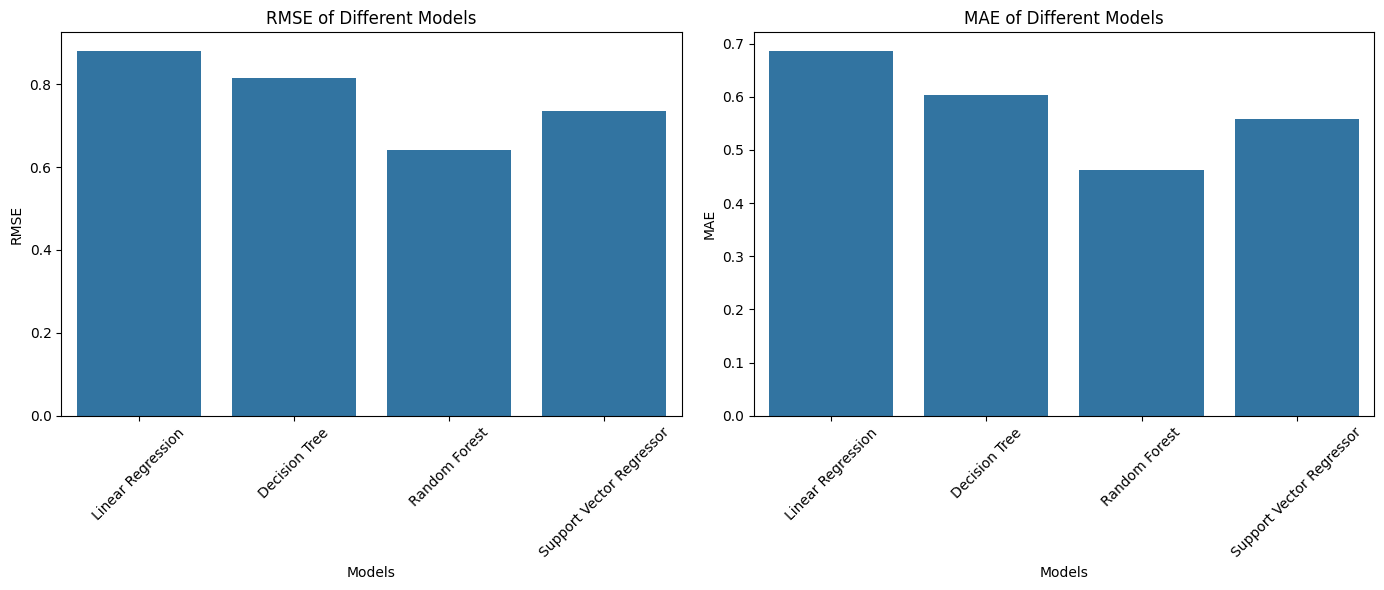

In [80]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR()
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae
    
results = {}

# Evaluate each model
for name, model in models.items():
    rmse, mae = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"RMSE": rmse, "MAE": mae}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Plotting RMSE and MAE
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y="RMSE", data=results_df)
plt.title("RMSE of Different Models")
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.xlabel("Models")

plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y="MAE", data=results_df)
plt.title("MAE of Different Models")
plt.xticks(rotation=45)
plt.ylabel("MAE")
plt.xlabel("Models")

plt.tight_layout()
plt.show()

In [81]:
# Function to evaluate models with cross-validation
def cross_val_evaluate_model(model, X, y):
    cv = KFold(n_splits=4, shuffle=True, random_state=42)
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    return rmse_scores.mean(), mae_scores.mean()

# Dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    rmse, mae = cross_val_evaluate_model(model, X, y)
    results[name] = {"RMSE": rmse, "MAE": mae}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                              RMSE       MAE
Linear Regression         0.864132  0.681289
Decision Tree             0.831377  0.613049
Random Forest             0.644522  0.474502
Support Vector Regressor  0.724748  0.554963


In [82]:
# Feature engineering: Creating a new column 'Episode_Length'
df['Episode_Length'] = df['Duration'] / df['Episodes']

# Display the updated dataframe with the new feature
print(df[['Name', 'Episodes', 'Duration', 'Episode_Length']].sample(5))

                              Name  Episodes  Duration  Episode_Length
16676              Tiger & Bunny 2      13.0      24.0        1.846154
7102                Tanken Driland      37.0      20.0        0.540541
8314          Seitokai Yakuindomo*      13.0      23.0        1.769231
1077             Shamanic Princess       6.0      30.0        5.000000
11120  Owaranai Seraph: Nagoya-hen       4.0       4.0        1.000000


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Encode 'Award Winning' as a binary feature
df['Award Winning'] = df['Award Winning'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select relevant features for modeling
X = df[['Favorites', 'Members', 'Award Winning', 'Episode_Length']]
y = df['Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42) ##

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using metrics like RMSE and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Root Mean Squared Error (RMSE): 0.64
Mean Absolute Error (MAE): 0.46


/Users/ramyaamudapakula/miniconda3/envs/webapp2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:
# Feature importances
importances = model.feature_importances_
feature_names = ['Favorites', 'Members', 'Award Winning', 'Episodes']
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
Favorites        0.625593
Members          0.276692
Episodes         0.095492
Award Winning    0.002223
dtype: float64


In [86]:
# choosing other features
def preprocess_for_modeling(df):
    df_model = df.copy()
    df_model['Award Winning'] = df_model['Award Winning'].apply(lambda x: 1 if x == 'Yes' else 0)
    df_model['Episodes'] = df_model['Episodes'].fillna(df_model['Episodes'].median())
    df_model = df_model.dropna(subset=['Score'])
    return df_model

df_model = preprocess_for_modeling(df)
X = df_model[['Favorites', 'Members', 'Popularity', 'Rank']]
y = df_model['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

#best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


       Favorites  Members  Popularity     Rank  Actual  Predicted  \
3554       55666  2121399          22    487.0    8.08    8.08000   
16137          5     2533        9937   2954.0    7.22    7.21995   
23296        315    54870        2764    274.0    8.27    8.26955   
19264          0      912       12924  10650.0    5.54    5.54000   
14058          1     1126       12261  12576.0    4.20    4.19925   

          Residuals  
3554   1.598721e-14  
16137  5.000000e-05  
23296  4.500000e-04  
19264  1.509903e-14  
14058  7.500000e-04  


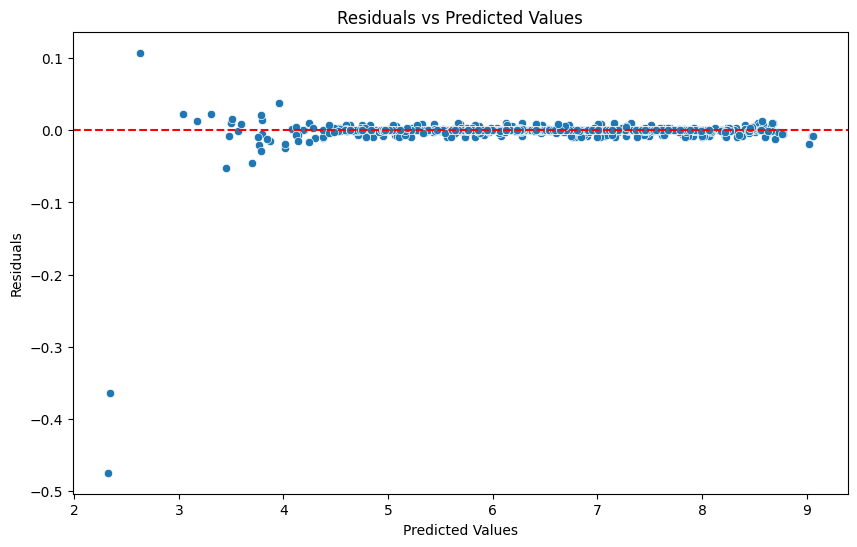

RMSE: 0.013583633471742726
MAE: 0.0013187351965989432


In [88]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Concatenate true values, predictions, and residuals
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['Residuals'] = residuals

# Analyze residuals
print(results_df.head())

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted', y='Residuals', data=results_df)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")